In [5]:
# Librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.stats import uniform, randint
from random import random, seed
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold

from xgboost import plot_importance

import time
import warnings 
#warnings.filterwarnings("ignore")

%matplotlib inline
import joblib

In [7]:
# 1. Carga de los datos
data_top10=pd.read_csv('../../Data/data_top10_country.csv') # to read data from github
data_top10.head(3)

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,company_country,employee_country
0,MI,FT,Data Scientist,111740,North America,0,North America,M,United States,United States
1,SE,FT,Data Scientist,115000,North America,100,North America,M,United States,United States
2,SE,FT,Machine Learning Engineer,112000,North America,0,North America,M,United States,United States


In [4]:
# 2.  Separación Entrenamiento y Prueba
data_top10.columns
data_top10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11193 entries, 0 to 11192
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   experience_level    11193 non-null  object
 1   employment_type     11193 non-null  object
 2   job_title           11193 non-null  object
 3   salary_in_usd       11193 non-null  int64 
 4   employee_residence  11193 non-null  object
 5   remote_ratio        11193 non-null  int64 
 6   company_location    11193 non-null  object
 7   company_size        11193 non-null  object
 8   company_country     11193 non-null  object
 9   employee_country    11193 non-null  object
dtypes: int64(2), object(8)
memory usage: 874.6+ KB


In [8]:
# Preparación de Datos
# Treat 'remote_ratio' as a categorical feature by converting it to 'object' type
data_top10['remote_ratio'] = data_top10['remote_ratio'].astype(str)
# Eliminación columnas redundantes o innecesarias en X_r
columns_to_drop_regression = ['salary_in_usd','employee_residence', 'company_location', 'employment_type', 
                              'company_size','remote_ratio'] # 3 ultimas no son importantes para el modelo

# sample for regression
y_r = data_top10['salary_in_usd']
X_r = data_top10.drop(columns_to_drop_regression, axis=1)
X_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11193 entries, 0 to 11192
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   experience_level  11193 non-null  object
 1   job_title         11193 non-null  object
 2   company_country   11193 non-null  object
 3   employee_country  11193 non-null  object
dtypes: object(4)
memory usage: 349.9+ KB


In [ ]:
# Funcion Random_Search
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)
from sklearn.model_selection import RepeatedStratifiedKFold
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=52)
                                
def random_search(model, param_grid, X_train, y_train, cv=kfold, n_iter=30, scoring="accuracy"): 
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring=scoring
    )
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60  # Time in minutes
    
    return random_search, elapsed_time
def report_best_scores(results, n_top=3):
    # Esta función espera una instancia de resultados de búsqueda de cross validation, por ejemplo: search.cv_results_
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
    # Retorna los parámetros del mejor modelo basado en accuracy.
    return list(results.sort_values("rank_test_score")['params'])[0]

def see_results(results):
    # Esta función espera una instancia de pandas dataframe de los resultados de búsqueda de cross validation, por ejemplo: pd.DataFrame(search.cv_results_)
    display(results[results.columns.drop(list(results.filter(regex='split')))].sort_values("rank_test_score"))


In [9]:
# Separación Train/Test
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=77)
cat_features = Xr_train.columns.tolist() 

In [20]:
# Model CatBoost Regressor
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(
    random_state=42,
    verbose=0,  # Suppress output for brevity
    loss_function='RMSE',
    cat_features=cat_features 
)

# Parameter grid for CatBoost
param_grid_catboost = {
    'iterations': randint(100, 1000),
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.1),
    'l2_leaf_reg': uniform(0.2, 3)
}

In [21]:
# Run RandomizedSearchCV on CatBoost
rs_cbr, elapsed_time_cbr = random_search(catboost_model, param_grid_catboost, Xr_train, yr_train, scoring = "neg_mean_squared_error")
print(f"Tiempo de entrenamiento {elapsed_time_cbr:.2f} minutos")


Fitting 15 folds for each of 30 candidates, totalling 450 fits


/Users/alejandra/anaconda3/envs/MIAD_DESP/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/alejandra/anaconda3/envs/MIAD_DESP/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/alejandra/anaconda3/envs/MIAD_DESP/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Tiempo de entrenamiento 3.04 minutos


In [22]:

# Ver resultados
see_results(pd.DataFrame(rs_cbr.cv_results_))
best_models_params_cbr= report_best_scores(pd.DataFrame(rs_cbr.cv_results_))
best_models_params_cbr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,params,mean_test_score,std_test_score,rank_test_score
9,0.872378,0.149869,0.005359,0.002567,4,230,2.779821,0.078031,"{'depth': 4, 'iterations': 230, 'l2_leaf_reg':...",-3.248932e+09,6.226472e+07,1
22,1.411154,0.023021,0.004757,0.001375,4,443,1.384645,0.039349,"{'depth': 4, 'iterations': 443, 'l2_leaf_reg':...",-3.248979e+09,6.309828e+07,2
14,2.225687,0.307889,0.004777,0.001436,4,661,2.187567,0.041171,"{'depth': 4, 'iterations': 661, 'l2_leaf_reg':...",-3.250748e+09,6.291896e+07,3
24,1.494288,0.025587,0.003794,0.000804,4,478,0.422134,0.045847,"{'depth': 4, 'iterations': 478, 'l2_leaf_reg':...",-3.251688e+09,6.282234e+07,4
5,1.865730,0.299166,0.004605,0.001275,4,559,2.034959,0.010707,"{'depth': 4, 'iterations': 559, 'l2_leaf_reg':...",-3.252023e+09,6.095895e+07,5
29,0.285313,0.021165,0.003808,0.001006,4,104,1.883832,0.087097,"{'depth': 4, 'iterations': 104, 'l2_leaf_reg':...",-3.252836e+09,5.978208e+07,6
25,0.338873,0.009991,0.003511,0.000750,4,127,2.789310,0.072330,"{'depth': 4, 'iterations': 127, 'l2_leaf_reg':...",-3.252996e+09,5.970668e+07,7
6,2.108439,0.245411,0.004266,0.001600,4,660,1.774324,0.049986,"{'depth': 4, 'iterations': 660, 'l2_leaf_reg':...",-3.253754e+09,6.354399e+07,8
20,1.312725,0.141045,0.004307,0.001027,5,316,1.042804,0.064270,"{'depth': 5, 'iterations': 316, 'l2_leaf_reg':...",-3.254476e+09,6.360781e+07,9
11,3.786615,0.489572,0.011573,0.006572,9,341,1.356250,0.011597,"{'depth': 9, 'iterations': 341, 'l2_leaf_reg':...",-3.255253e+09,5.895587e+07,10


Model with rank: 1
Mean validation score: -3248931959.787 (std: 62264716.322)
Parameters: {'depth': 4, 'iterations': 230, 'l2_leaf_reg': 2.779821220208962, 'learning_rate': 0.07803075385877797}

Model with rank: 2
Mean validation score: -3248979368.518 (std: 63098277.077)
Parameters: {'depth': 4, 'iterations': 443, 'l2_leaf_reg': 1.384644554526709, 'learning_rate': 0.03934881747180381}

Model with rank: 3
Mean validation score: -3250748456.147 (std: 62918962.836)
Parameters: {'depth': 4, 'iterations': 661, 'l2_leaf_reg': 2.187566853061946, 'learning_rate': 0.0411711076089411}



{'depth': 4,
 'iterations': 230,
 'l2_leaf_reg': 2.779821220208962,
 'learning_rate': 0.07803075385877797}

In [23]:
# Best parameters and score
best_params_cbr = rs_cbr.best_params_
best_score_cbr = rs_cbr.best_score_
best_rmse_cbr = np.sqrt(-best_score_cbr)

print(f"Best Parameters CatBoostRegressor: {best_params_cbr}")
print(f"Best Cross-Validation Score CatBoostRegressor: {best_score_cbr:.4f}")
print(f"Best RMSE CatBoostRegressor: {best_rmse_cbr:.4f}")

Best Parameters CatBoostRegressor: {'depth': 4, 'iterations': 230, 'l2_leaf_reg': 2.779821220208962, 'learning_rate': 0.07803075385877797}
Best Cross-Validation Score CatBoostRegressor: -3248931959.7867
Best RMSE CatBoostRegressor: 56999.4032


Test RMSE: 56035.5504435264


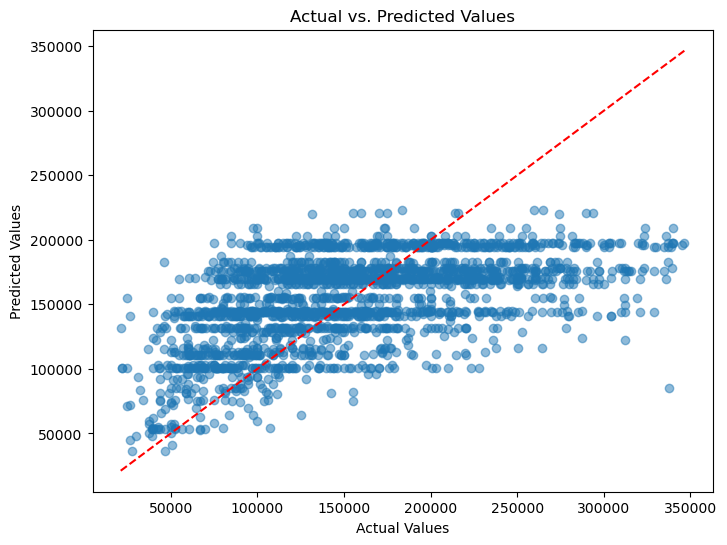

In [24]:
# Evaluacion Modelo
best_cbr_model = rs_cbr.best_estimator_
# Evaluate the best model on the test set
y_pred_cbr = best_cbr_model.predict(Xr_test)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse_test = np.sqrt(mean_squared_error(yr_test, y_pred_cbr))
print(f"Test RMSE: {rmse_test}")
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(yr_test, y_pred_cbr, alpha=0.5)
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--')  # Line for perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

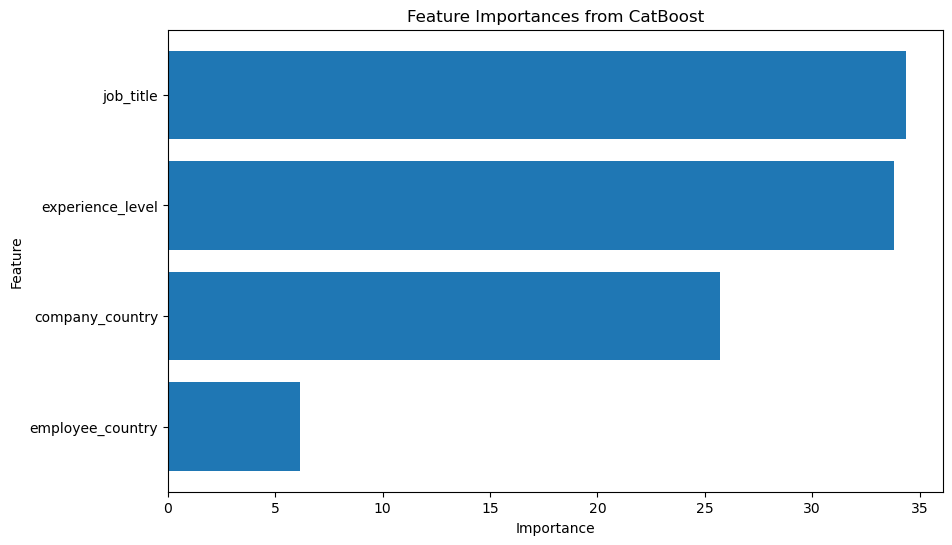

In [19]:

# Feature importances
feature_importances = best_cbr_model.feature_importances_
feature_names = Xr_train.columns  # Original feature names

# Combine into a DataFrame 
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot 
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from CatBoost")
plt.gca().invert_yaxis()
plt.show()

In [ ]:

#Save the best model
#joblib.dump(best_cbr_model, 'best_cbr_reg_model.pkl')  